In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data sources
import yfinance as yf
from fredapi import Fred

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pd.options.display.max_rows = 500
%matplotlib inline 

# Gather Data

In [2]:
api_key = 'b27994ea92311f213e0e709cdd98849b' # hidden
fred = Fred(api_key)

In [3]:
# Set period
start = datetime(1999, 1, 1)
end = date.today() # '2024-06-02'

# Gather series
vix = fred.get_series('VIXCLS', start, end)
vix_lag_1month = vix.shift(21) # Also add previous values of volatility
interest_rates = fred.get_series('FEDFUNDS', start, end)
gdp = fred.get_series('GDP', start, end)
gdp_growth = gdp.pct_change() * 100
cpi = fred.get_series('CPIAUCSL', start, end)
unemployment = fred.get_series('UNRATE', start, end)
housing_starts = fred.get_series('HOUST', start, end)
home_prices = fred.get_series('CSUSHPINSA', start, end)
usd_idx = yf.download('DX-Y.NYB', start, end)['Adj Close']
corporate_bond_yields = fred.get_series('BAMLC0A4CBBBEY', start, end)
treasury_yields = fred.get_series('DGS10', start, end)

# Gather S&P500 Data
sp500 = yf.download('^GSPC', start=start, end=end)
# Gather Returns in unit percentage
sp500['Returns'] = sp500['Adj Close'].pct_change() * 100
# Gather response variable
squared_returns = np.square(sp500['Returns'])
volatility = np.sqrt(squared_returns.rolling(window=21).sum()) # * (np.sqrt(252)) Annualized volatility
# Create logged volatility
log_volatility = np.log(volatility)
# Create lagged AR term
volatility_lag_1month = volatility.shift(21)
# Gather Volume regressor
volume = sp500['Volume']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1]:
plt.hist(volatility)

NameError: name 'plt' is not defined

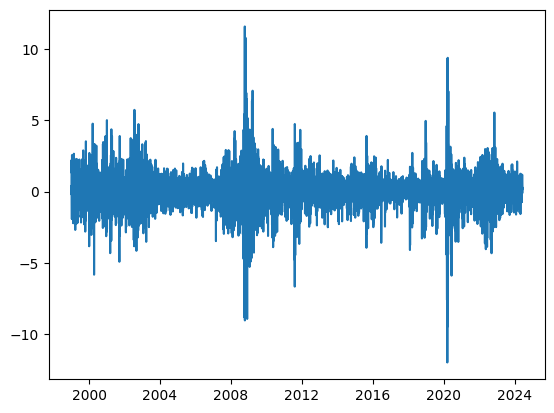

In [10]:
plt.plot(sp500['Returns'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          2.,   0.,   2.,   1.,   2.,   0.,   4.,   2.,   5.,   3.,   8.,
          5.,   8.,   7.,  17.,  19.,  32.,  25.,  51.,  55.,  69., 108.,
        145., 167., 219., 327., 413., 580., 828., 829., 629., 510., 354.,
        275., 197., 145.,  84.,  56.,  58.,  38.,  14.,  21.,  10.,  15.,
          5.,  12.,   5.,   5.,   4.,   4.,   2.,   2.,   1.,   1.,   1.,
          3.,   1.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([-0.11984055, -0.11748414, -0.11512773, -0.11277132, -0.11041492,
        -0.10805851, -0.1057021 , -0.10334569, -0.10098928, -0.09863287,
        -0.09627646, -0.09392005, -0.09156364, -0.08920723, -0.08685082,
        -0.08449441, -0.082138  , -0.0797816 , -0.07742519, -0.07506878,
        -0.07271237, -0.07

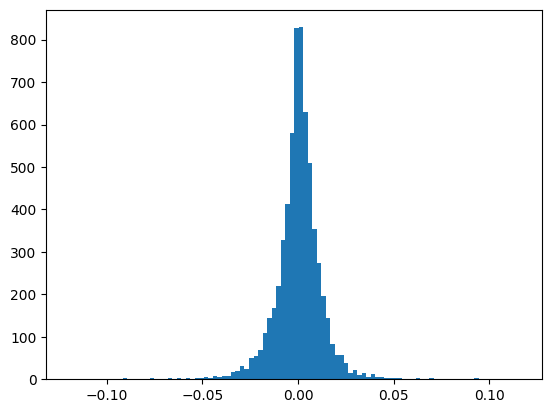

In [8]:
plt.hist(sp500['Returns'], bins = 100)

In [9]:
# Combine all macro series into one dataframe
combined_df = pd.concat([
    rolling_realized_volatility,
    volatility,
    log_volatility,
    volatility_lag_1month,
    volume, 
    vix,
    vix_lag_1month,
    interest_rates,
    gdp,
    gdp_growth,
    cpi,
    unemployment,
    housing_starts,
    home_prices,
    usd_idx,
    corporate_bond_yields,
    treasury_yields
], axis=1)

# Set columns
combined_df.columns = [
    'rolling_realized_volatility',
    'Volatility',
    "Logged_Volatility",
    "Volatility_Lag_One_Month",
    "Volume",
    'VIX', 
    'VIX_Lag_One_Month',
    'Interest_Rates', 
    'GDP', 
    'GDP_Growth',
    'CPI', 
    'Unemployment_Rate', 
    'Housing_Starts', 
    'Home_Prices', 
    'US_Dollar_Index', 
    'Corporate_Bond_Yields', 
    'Ten_Year_Treasury_Yield'
]

combined_df = sm.add_constant(combined_df)

In [10]:
combined_df.describe()



,const,rolling_realized_volatility,Volatility,Logged_Volatility,Volatility_Lag_One_Month,Volume,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
count,6807.0,6379.000000,6379.000000,6379.000000,6358.000000,6.400000e+03,6416.000000,6395.000000,305.000000,101.000000,100.000000,304.000000,305.000000,304.000000,303.000000,6434.000000,6643.000000,6363.000000
mean,1.0,0.047552,0.165408,-1.938498,0.165612,3.239321e+09,20.113147,20.137245,1.968689,16673.710366,1.115649,225.185263,5.671475,1317.953947,175.592587,92.606380,5.134093,3.357691
std,0.0,0.029909,0.104993,0.504737,0.105103,1.550446e+09,8.417278,8.420465,2.041397,4918.565077,1.434272,37.199326,1.953541,434.340011,54.328443,11.248197,1.682023,1.371760
min,1.0,0.010976,0.034728,-3.360219,0.034728,3.121200e+08,9.140000,9.140000,0.050000,9411.682000,-8.261898,164.700000,3.400000,478.000000,92.714000,71.330002,2.050000,0.520000
25%,1.0,0.028724,0.099465,-2.307948,0.099519,1.795368e+09,13.990000,14.010000,0.140000,12922.656000,0.810231,193.675000,4.200000,1009.250000,141.416500,82.550003,3.750000,2.220000
50%,1.0,0.040326,0.140931,-1.959488,0.141163,3.411060e+09,18.310000,18.340000,1.240000,15647.680000,1.175658,226.351500,5.000000,1341.000000,166.657000,93.045002,4.980000,3.360000
75%,1.0,0.057555,0.200091,-1.608983,0.200578,4.118810e+09,23.890000,23.905000,3.780000,19913.143000,1.522865,248.068500,6.300000,1635.250000,195.648000,99.959999,6.220000,4.405000
max,1.0,0.273251,0.968347,-0.032165,0.968347,1.145623e+10,82.690000,82.690000,6.540000,28255.928000,8.710313,313.207000,14.800000,2273.000000,316.646000,120.900002,10.230000,6.790000


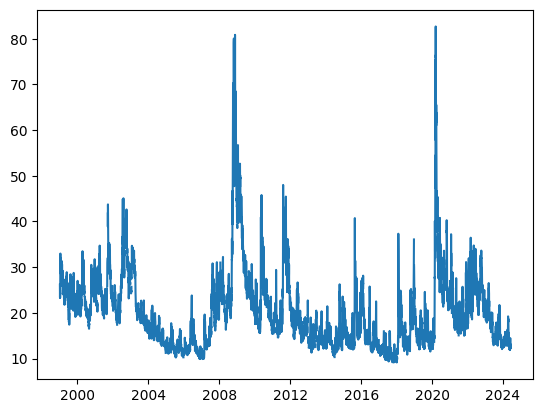

In [12]:
plt.plot(vix)

In [13]:
# Let's view our dataset
combined_df

,const,rolling_realized_volatility,Volatility,Logged_Volatility,Volatility_Lag_One_Month,Volume,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
1999-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.63,9411.682,NaN,164.7,4.3,1748.0,92.714,94.169998,NaN,NaN
1999-01-04,1.0,NaN,NaN,NaN,NaN,8.770000e+08,26.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.440002,6.72,4.69
1999-01-05,1.0,NaN,NaN,NaN,NaN,7.750000e+08,24.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.470001,6.78,4.74
1999-01-06,1.0,NaN,NaN,NaN,NaN,9.869000e+08,23.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.529999,6.75,4.73
1999-01-07,1.0,NaN,NaN,NaN,NaN,8.630000e+08,24.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.720001,6.80,4.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04,1.0,0.024070,8.184072,-2.502980,14.199845,3.707900e+09,13.16,13.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.110001,5.62,4.33
2024-06-05,1.0,0.024761,8.404618,-2.476389,14.125063,3.591460e+09,12.63,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.269997,5.59,4.29
2024-06-06,1.0,0.024726,8.427093,-2.473718,14.134595,3.609990e+09,12.58,13.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.099998,5.60,4.28
2024-06-07,1.0,0.024751,8.460895,-2.469715,14.123577,3.692760e+09,12.22,12.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.889999,5.72,NaN


In [14]:
# Forward Fill imputation
combined_df.fillna(method='ffill', inplace=True)
# Let's select from 2000 onwards
combined_df = combined_df[combined_df.index.get_loc('2000-01-01'):]
# Let's view our dataframe
combined_df.tail(20)

,const,rolling_realized_volatility,Volatility,Logged_Volatility,Volatility_Lag_One_Month,Volume,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2024-05-14,1.0,0.033686,11.619362,-2.152497,11.886607,4.763580e+09,13.42,19.23,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.010002,5.73,4.45
2024-05-15,1.0,0.035606,12.025473,-2.118143,11.717649,4.360810e+09,12.45,18.40,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.349998,5.63,4.36
2024-05-16,1.0,0.035195,11.774420,-2.139241,11.567627,3.817470e+09,12.42,18.21,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.459999,5.66,4.38
2024-05-17,1.0,0.035145,11.659475,-2.149051,11.301592,3.578120e+09,11.99,18.00,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.449997,5.69,4.42
2024-05-20,1.0,0.034048,10.916575,-2.214888,10.893981,3.420100e+09,12.15,18.71,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.570000,5.70,4.44
2024-05-21,1.0,0.033005,10.729724,-2.232152,11.405233,3.662240e+09,11.86,16.94,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.660004,5.68,4.41
2024-05-22,1.0,0.030878,10.363974,-2.266834,12.406984,3.847130e+09,12.29,15.69,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.940002,5.70,4.43
2024-05-23,1.0,0.031748,10.868350,-2.219315,12.406433,3.869520e+09,12.77,15.97,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,105.110001,5.75,4.47
2024-05-24,1.0,0.032187,10.747572,-2.230490,12.448210,3.005510e+09,11.93,15.37,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.720001,5.75,4.46
2024-05-27,1.0,0.032187,10.747572,-2.230490,12.448210,3.005510e+09,12.36,15.03,5.33,28255.928,1.069249,313.207,4.0,1360.0,316.646,104.720001,5.75,4.46


# Plot data

In [15]:
# plt.figure(figsize=(7,7))
# plt.plot(gdp, data=combined_df)
# plt.xlabel('Years')
# plt.ylabel('GDP in billions')
# plt.title('US GDP from 2000-2024 in billions')

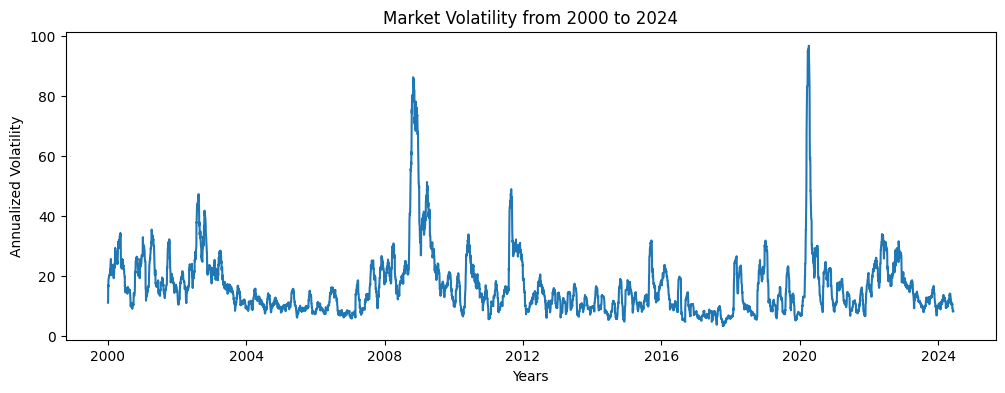

In [16]:
# Plotting volatility
plt.figure(figsize=(12,4))
plt.title("Market Volatility from 2000 to 2024")
plt.xlabel("Years")
plt.ylabel("Annualized Volatility")
plt.plot(combined_df['Volatility'])

In [17]:
combined_df[combined_df.isna().any(axis=1)].empty
# There are no NANs in our dataframe

True

# Regression

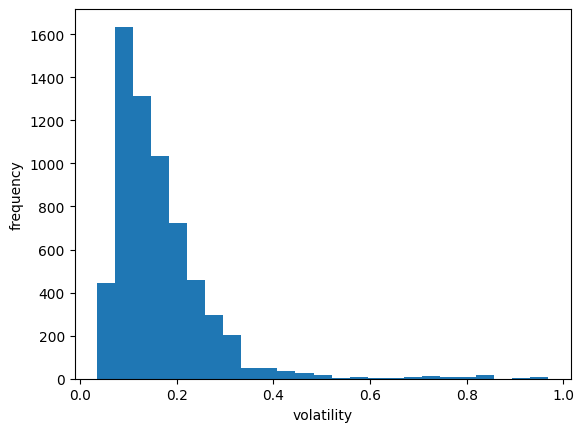

In [18]:
# Histogram of response
plt.hist(volatility, bins=25)
plt.ylabel('frequency')
plt.xlabel('volatility')
plt.show()
# sns.kdeplot(vix)

(array([  33.,  280., 1032., 1529., 1540., 1178.,  555.,  136.,   34.,
          62.]),
 array([-3.36021889, -3.02741349, -2.69460808, -2.36180268, -2.02899728,
        -1.69619188, -1.36338647, -1.03058107, -0.69777567, -0.36497027,
        -0.03216486]),
 <BarContainer object of 10 artists>)

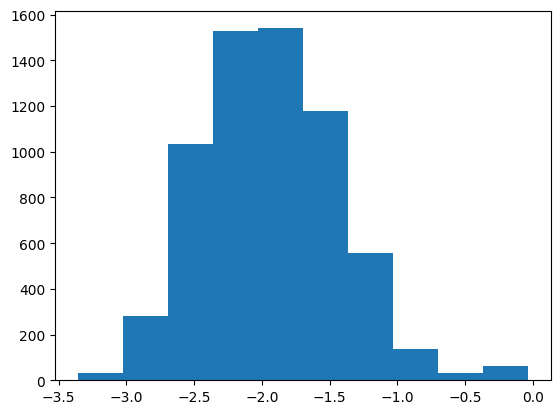

In [19]:
# Log transform?
log_volatility = np.log(volatility)
plt.hist(log_volatility)

In [20]:
log_volatility.dropna(inplace=True)

<Figure size 1000x600 with 0 Axes>

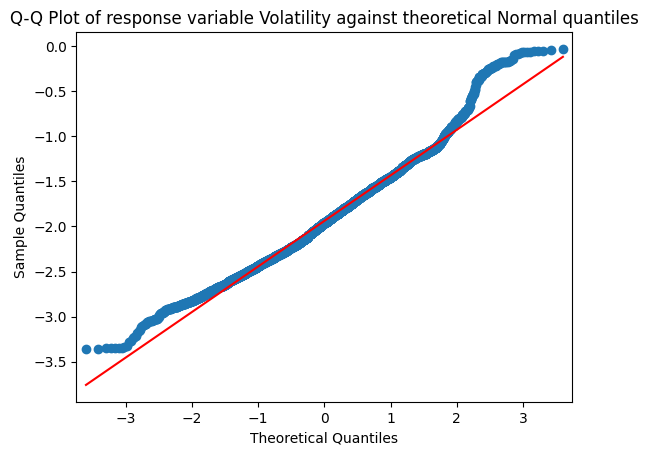

In [21]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(log_volatility, line='s')
# stats.probplot(log_volatility, dist="norm", plot=plt)
plt.title("Q-Q Plot of response variable Volatility against theoretical Normal quantiles")
plt.show()

In [22]:
combined_df.head()

,const,rolling_realized_volatility,Volatility,Logged_Volatility,Volatility_Lag_One_Month,Volume,VIX,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2000-01-01,1.0,0.033295,11.153668,-2.193402,12.812371,3.740500e+08,24.64,21.77,5.45,10002.179,1.030386,169.3,4.0,1636.0,100.0,101.870003,8.10,6.45
2000-01-03,1.0,0.033678,11.681040,-2.147203,12.793144,9.318000e+08,24.21,19.32,5.45,10002.179,1.030386,169.3,4.0,1636.0,100.0,100.220001,8.22,6.58
2000-01-04,1.0,0.048042,16.962012,-1.774194,13.789161,1.009000e+09,27.01,20.58,5.45,10002.179,1.030386,169.3,4.0,1636.0,100.0,100.410004,8.15,6.49
2000-01-05,1.0,0.047575,16.853173,-1.780631,14.137085,1.085500e+09,26.41,21.09,5.45,10002.179,1.030386,169.3,4.0,1636.0,100.0,100.379997,8.24,6.62
2000-01-06,1.0,0.046533,16.515923,-1.800845,14.671193,1.092300e+09,25.73,21.25,5.45,10002.179,1.030386,169.3,4.0,1636.0,100.0,100.650002,8.19,6.57


In [38]:
# Test model
# Fit the multivariable regression model
test = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test.summary())

                                 OLS Regression Results                                
Dep. Variable:     rolling_realized_volatility   R-squared:                       0.668
Model:                                     OLS   Adj. R-squared:                  0.668
Method:                          Least Squares   F-statistic:                     1012.
Date:                         Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                                 10:47:49   Log-Likelihood:                 17200.
No. Observations:                         6540   AIC:                        -3.437e+04
Df Residuals:                             6526   BIC:                        -3.428e+04
Df Model:                                   13                                         
Covariance Type:                     nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

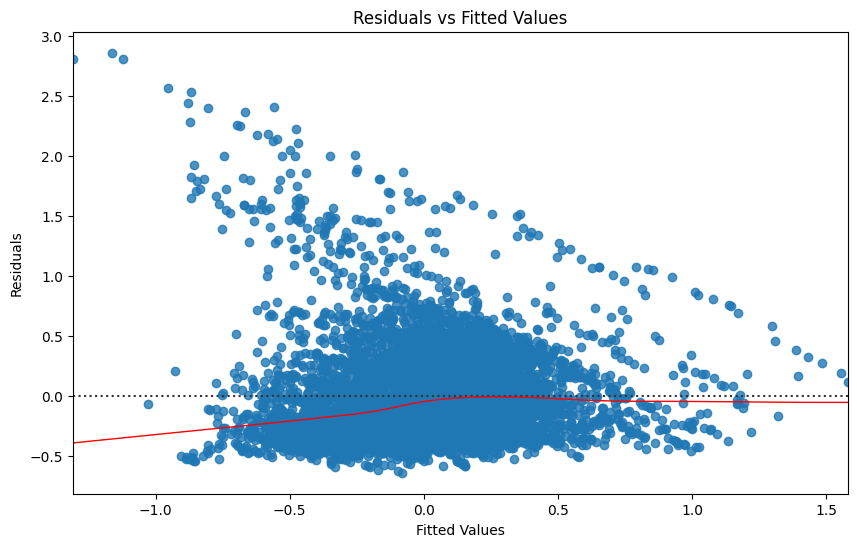

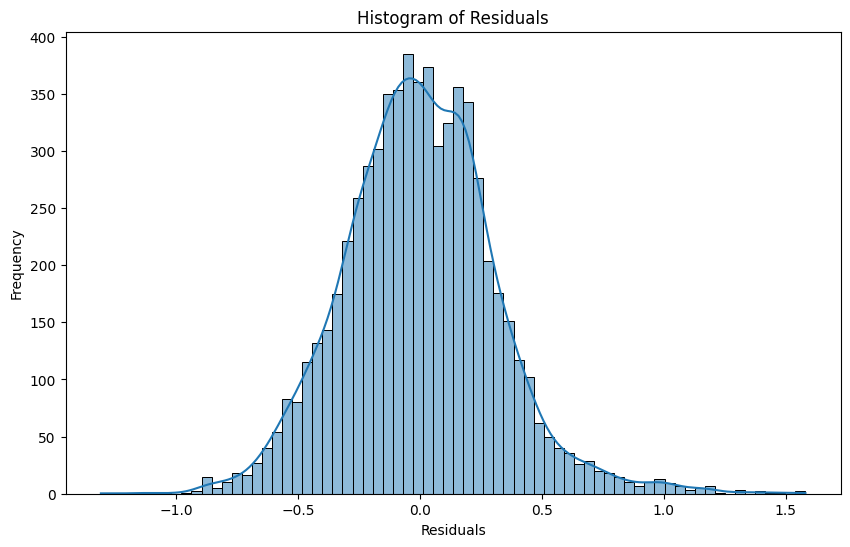

In [24]:
# Extract residuals and fitted values
resids = test.resid
fitted_values = test.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Could think about doing a Cook's distance thing like in the lecture 6 example to eliminate extreme points

<Figure size 1000x600 with 0 Axes>

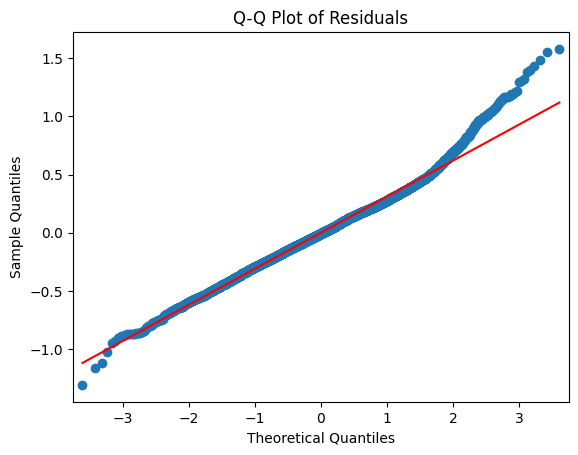

In [25]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(resids, line='r')
# stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

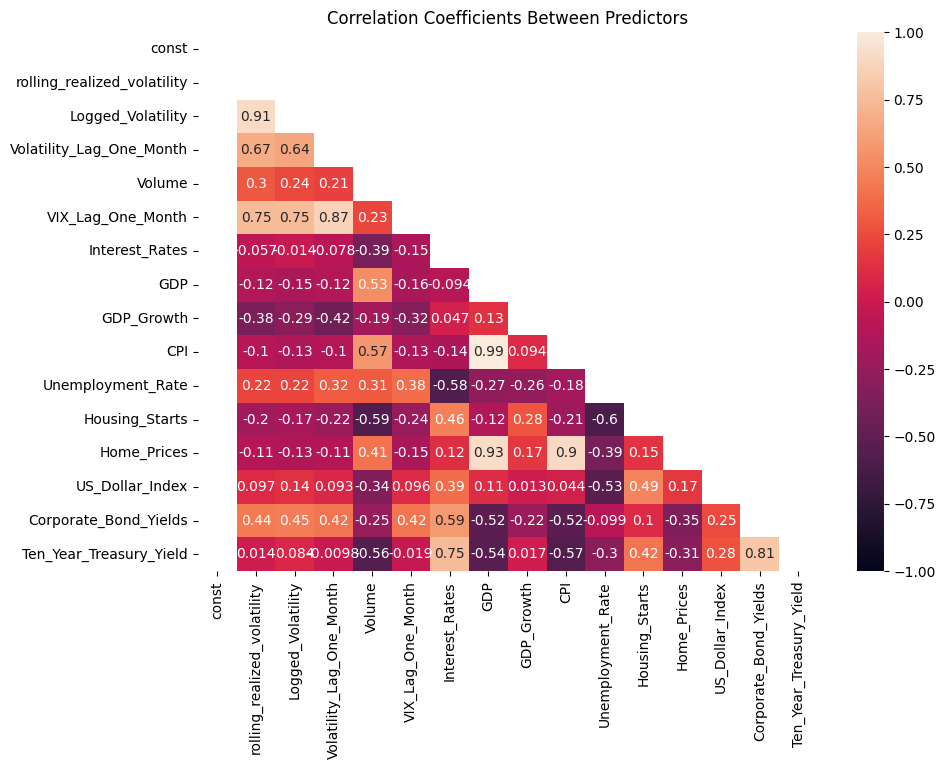

In [26]:
# Test for multicollinearity
plt.figure(figsize=(10,7))

predictors = combined_df.drop(columns=["VIX", 'Volatility'])
mask = np.triu(np.ones_like(predictors.corr(), dtype=bool))
sns.heatmap(predictors.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients Between Predictors')
plt.show()

In [27]:
# Test for homoskedasticity


In [28]:
# Fit the multivariable regression model
model = smf.ols(formula = 'VIX ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1266.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:47:43   Log-Likelihood:                -19166.
No. Observations:                6540   AIC:                         3.836e+04
Df Residuals:                    6526   BIC:                         3.845e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [29]:
# ANOVA
anova_result = sm.stats.anova_lm(model, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
VIX_Lag_One_Month,12161.166556,1.0,590.351301,6.486355e-125
Volatility_Lag_One_Month,37.031157,1.0,1.797639,1.800448e-01
Volume,19229.646942,1.0,933.483399,9.776145e-192
Interest_Rates,1128.160001,1.0,54.765365,1.528845e-13
GDP,227.968638,1.0,11.066503,8.838715e-04
GDP_Growth,391.880307,1.0,19.023426,1.311097e-05
CPI,93.541928,1.0,4.540897,3.313153e-02
Unemployment_Rate,89.719604,1.0,4.355346,3.693168e-02
Housing_Starts,1613.874761,1.0,78.343888,1.099721e-18
Home_Prices,4.886168,1.0,0.237194,6.262565e-01


# Plots

Text(0, 0.5, '$Bn')

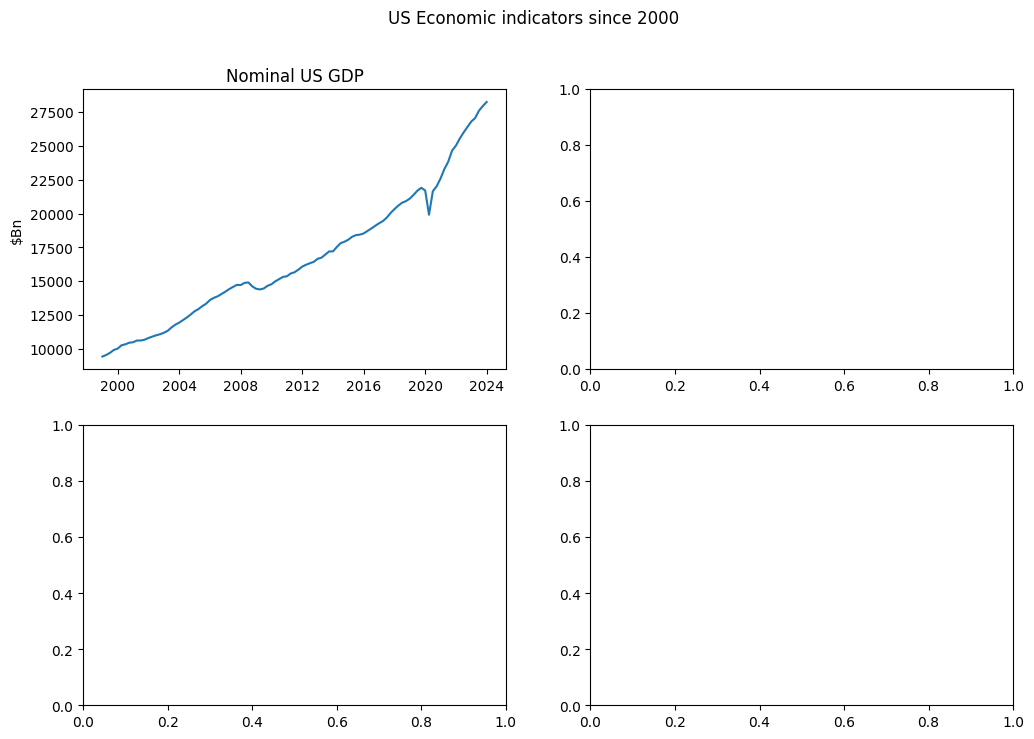

In [30]:
fig, axs  = plt.subplots(2, 2,figsize=(12, 8))
fig.suptitle('US Economic indicators since 2000')

axs[0][0].plot(gdp)
axs[0][0].set_title("Nominal US GDP")
axs[0,0].set_ylabel("$Bn")

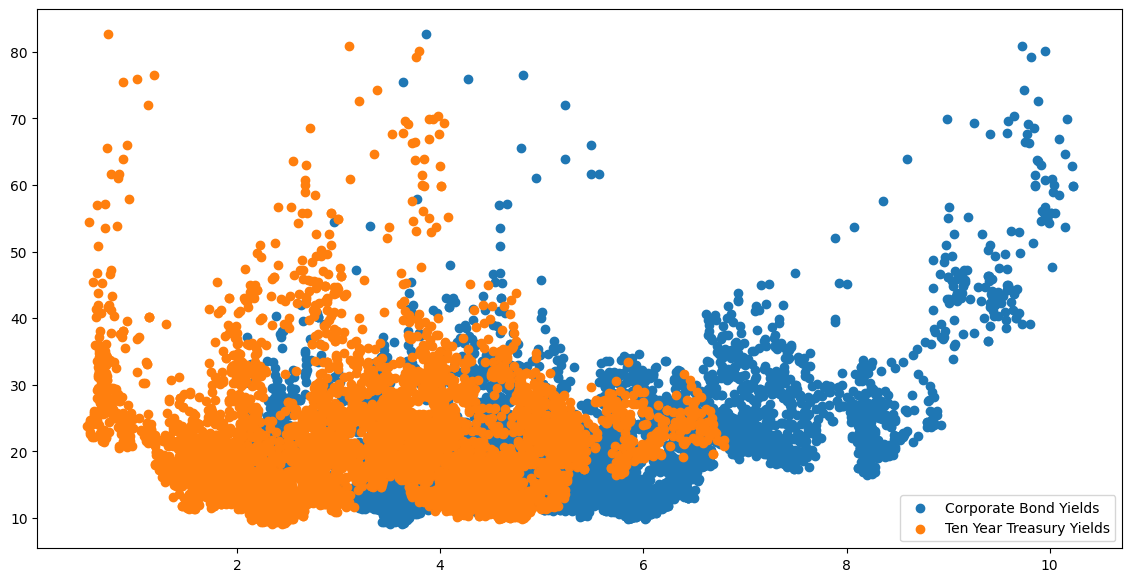

In [31]:
plt.figure(figsize=(14,7))
plt.scatter("Corporate_Bond_Yields", "VIX", label='Corporate Bond Yields', data=combined_df)
plt.scatter("Ten_Year_Treasury_Yield", "VIX", label='Ten Year Treasury Yields', data=combined_df)
plt.legend()

In [32]:
# Extract residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues

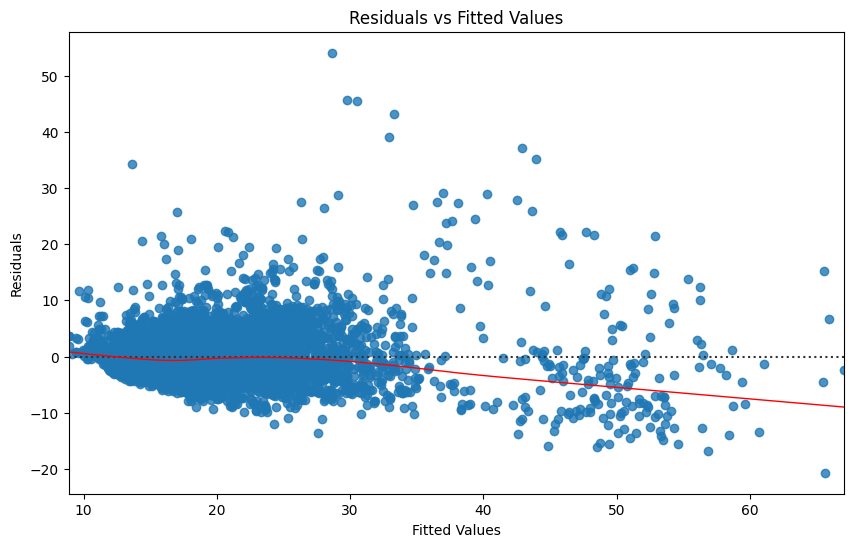

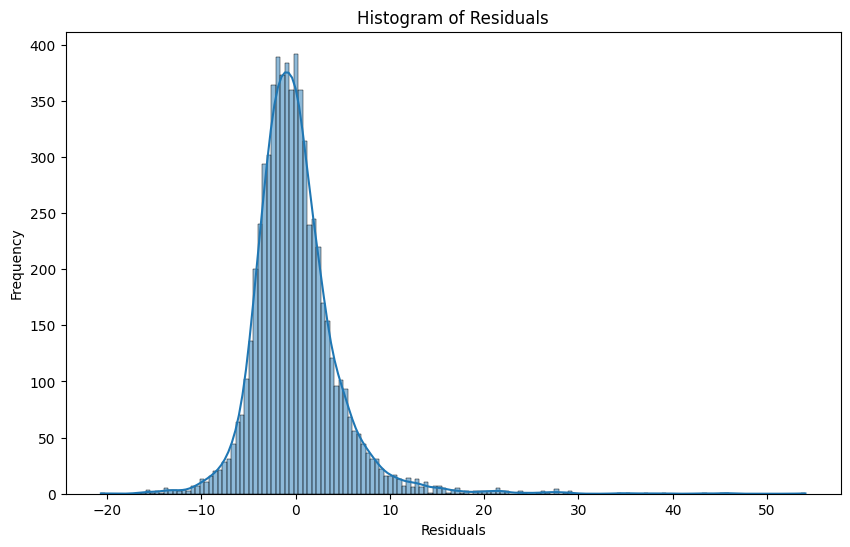

In [33]:
# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

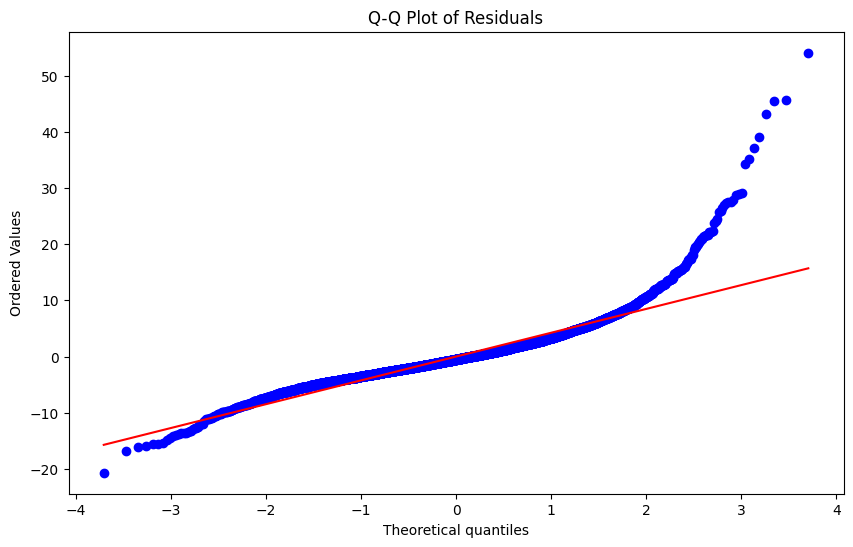

In [34]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Run new model

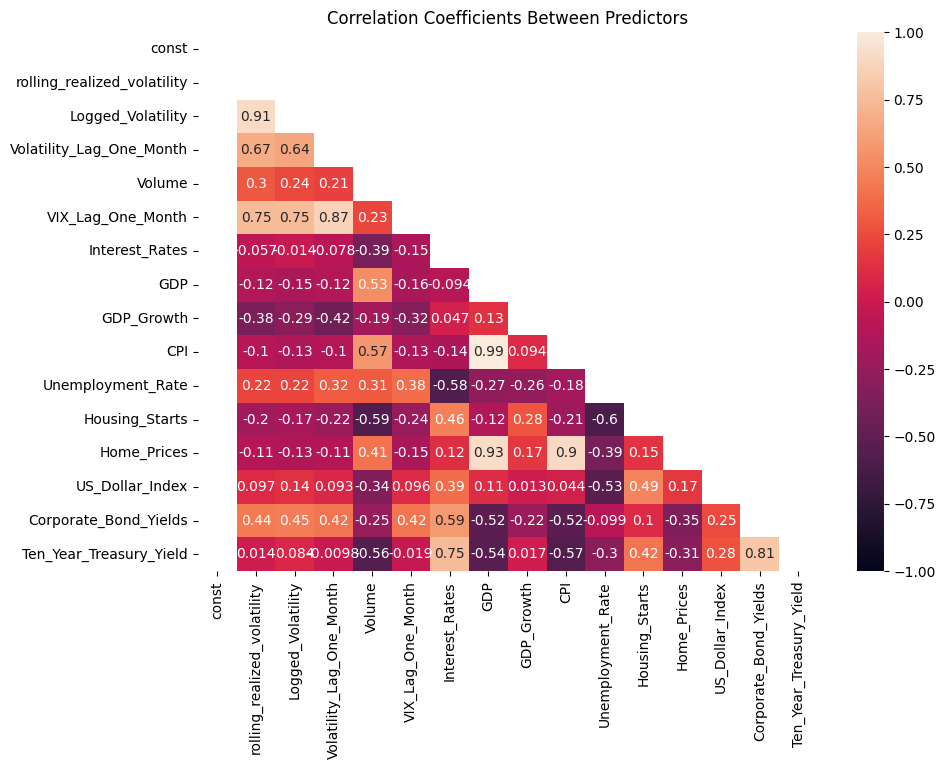

In [35]:
# Test for multicollinearity
plt.figure(figsize=(10,7))

predictors = combined_df.drop(columns=["VIX", 'Volatility'])
mask = np.triu(np.ones_like(predictors.corr(), dtype=bool))
sns.heatmap(predictors.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients Between Predictors')
plt.show()

In [36]:
# Create new model
new_df = pd.concat([
    volatility,
    vix,
    vix_lag_1month,
    interest_rates,
    gdp,
    gdp_growth,
    cpi,
    unemployment,
    housing_starts,
    home_prices,
    usd_idx,
    corporate_bond_yields,
    treasury_yields
], axis=1)

# Set columns
new_df.columns = [
    'Volatility',
    'VIX', 
    'VIX_Lag_One_Month',
    'Interest_Rates', 
    'GDP', 
    'GDP_Growth',
    'CPI', 
    'Unemployment_Rate', 
    'Housing_Starts', 
    'Home_Prices', 
    'US_Dollar_Index', 
    'Corporate_Bond_Yields', 
    'Ten_Year_Treasury_Yield'
]

new_df = sm.add_constant(new_df)

In [37]:
# Fit the new multivariable regression model
model2 = smf.ols(formula = 'VIX ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Interest_Rates CPI + Unemployment_Rate + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(model2.summary())

SyntaxError: invalid syntax (<unknown>, line 1)